## Stock Prediction Part1
__In this project, MAV is baseline model. RNN, GRU and SLTM models were implemented (with experiments) to predict SPDR S&P 500 ETF Trust(SPY) stock price__

#### Data Part

In [1]:
# %pip install pandas_datareader
# %pip install mplfinance
# %pip install --upgrade mplfinance
# %pip install seaborn
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series,DataFrame
import numpy as np
import seaborn as sns

import mplfinance as mpl
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

In [2]:
# get data
def read_data(stock_name):
    start=datetime.datetime(1994,1,1)
    end=datetime.datetime(2022,11,11)

    stock_data=web.DataReader(stock_name,'yahoo',start,end)
    stock_data = stock_data.rename_axis('DATE').reset_index()
    
    return stock_data

# raw_data = read_data("SPY")
# raw_data.to_csv('./data/SPY_rawdata.csv')

In [3]:
# check data
data=pd.read_csv('./data/SPY_rawdata.csv',index_col=0)
data.shape

(7270, 7)

In [4]:
data.head()

,DATE,High,Low,Open,Close,Volume,Adj Close
0,1993-12-31,47.00000,46.56250,46.93750,46.59375,312900.0,27.540409
1,1994-01-03,46.65625,46.40625,46.59375,46.46875,960900.0,27.466526
2,1994-01-04,46.65625,46.46875,46.53125,46.65625,164300.0,27.577362
3,1994-01-05,46.78125,46.53125,46.71875,46.75000,710900.0,27.632753
4,1994-01-06,46.84375,46.68750,46.81250,46.75000,201000.0,27.632753


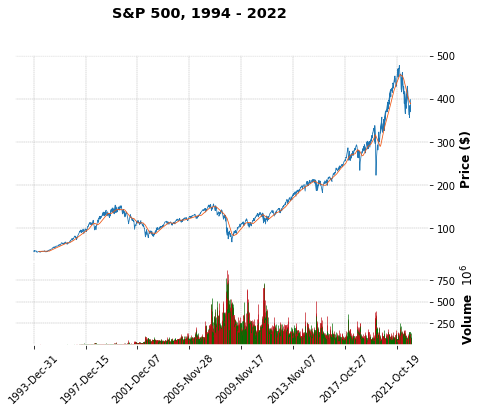

In [5]:
# visualization of SPY stock data
data_0 = data[['DATE', 'Open', 'High', 
         'Low', 'Close','Volume']]
  
# convert into datetime object
data_0['Date'] = pd.to_datetime(data_0['DATE'])
data_0.index=pd.DatetimeIndex(data_0.Date)

mpl.plot(data_0, type='line', style='charles',
            title='S&P 500, 1994 - 2022',
            ylabel='Price ($)',
            volume=True,
            mav=100 )# Add moving averages

### Orgnize data for training 
__把数据整成适合训练的样子__

In [6]:
data = data.set_index('DATE')
data

,High,Low,Open,Close,Volume,Adj Close
DATE,,,,,,
1993-12-31,47.000000,46.562500,46.937500,46.593750,312900.0,27.540409
1994-01-03,46.656250,46.406250,46.593750,46.468750,960900.0,27.466526
1994-01-04,46.656250,46.468750,46.531250,46.656250,164300.0,27.577362
1994-01-05,46.781250,46.531250,46.718750,46.750000,710900.0,27.632753
1994-01-06,46.843750,46.687500,46.812500,46.750000,201000.0,27.632753
...,...,...,...,...,...,...
2022-11-07,380.570007,375.529999,377.709991,379.950012,68286900.0,379.950012
2022-11-08,385.119995,377.720001,381.109985,382.000000,84641100.0,382.000000
2022-11-09,381.140015,373.609985,379.929993,374.130005,78495500.0,374.130005


In [7]:
# 筛选四个变量，作为数据的输入特征
sel_col = ['Open', 'High', 'Low', 'Close']  
df_main = data[sel_col]
df_main.head()


,Open,High,Low,Close
DATE,,,,
1993-12-31,46.93750,47.00000,46.56250,46.59375
1994-01-03,46.59375,46.65625,46.40625,46.46875
1994-01-04,46.53125,46.65625,46.46875,46.65625
1994-01-05,46.71875,46.78125,46.53125,46.75000
1994-01-06,46.81250,46.84375,46.68750,46.75000


In [8]:
# 查看是否有缺失值
np.sum(df_main.isnull())

Open     0
High     0
Low      0
Close    0
dtype: int64

In [9]:
# 数据缩放, 归一化，方便收敛
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))  
for col in sel_col:                           # 这里不能进行统一进行缩放，因为fit_transform返回值是numpy类型
    df_main[col] = scaler.fit_transform(df_main[col].values.reshape(-1,1))


/var/folders/tr/3_k_czmn2552n9rftmys1pwh0000gn/T/ipykernel_24349/1294159956.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main[col] = scaler.fit_transform(df_main[col].values.reshape(-1,1))
/var/folders/tr/3_k_czmn2552n9rftmys1pwh0000gn/T/ipykernel_24349/1294159956.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main[col] = scaler.fit_transform(df_main[col].values.reshape(-1,1))
/var/folders/tr/3_k_czmn2552n9rftmys1pwh0000gn/T/ipykernel_24349/1294159956.py:8: SettingWithCopyWarning: 
A value

In [10]:
df_main.dropna()                      # 使用了shift函数，在最后必然是有缺失值的，这里去掉缺失值所在行
df_main = df_main.astype(np.float32)  # 修改数据类型

## SMA benchmark

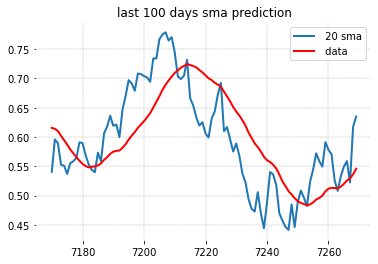

In [11]:
import matplotlib.ticker as ticker
close = df_main['Close']
close = close.reset_index()
close_df = pd.DataFrame(close)

x = close_df.DATE
#根据ticker的功能改变第一个为初始的数据，第二个则为距离
ticker_spacing = x
ticker_spacing = 50

window = 20
# trail-rolling average transform
rolling = close_df["Close"].rolling(window=window)
rolling_mean = rolling.mean()


plt.plot(close_df['Close'][-100:],label=" 20 sma")
plt.plot(rolling_mean[-100:], 'r',label=" data")
plt.title('last 100 days sma prediction')
plt.legend()

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
#import numpy as np 
print(f"SMA20 MSE：{mean_squared_error(close_df['Close'][21:], rolling_mean[21:])}") # start from the 21th day.

SMA20 MSE：0.0005404996569232601


#### RNNs Models building

In [13]:
# build LSTM model

input_dim = 4      # 数据的特征数
hidden_dim = 32    # 隐藏层的神经元个数
num_layers = 1     # 层数
output_dim = 1     # 预测值的特征数
                   #（这是预测股票价格，所以这里特征数是1，如果预测一个单词，那么这里是one-hot向量的编码长度）
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer 在LSTM后再加一个全连接层，因为是回归问题，所以不能在线性层后加激活函数
        self.fc = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        # Initialize hidden state with zeros   
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() 
        # 这里x.size(0)就是batch_size

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out


In [14]:
# GRU model
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
#RNN model
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.rnn(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [16]:

def split_data(df_main, seq):
    #df_main = df_main.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(df_main) - seq): 
        data.append(df_main[index: index + seq])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


In [17]:
# 设每条数据序列有20组数据
seq = 20

x_train, y_train, x_test, y_test = split_data(df_main, seq)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (5800, 19, 4)
y_train.shape =  (5800, 4)
x_test.shape =  (1450, 19, 4)
y_test.shape =  (1450, 4)


In [18]:
# tranfer data as tensor

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)


### Training

In [19]:
##训练模型

# 实例化模型
model_LSTM = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model_GRU = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model_RNN = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

optimiser_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=0.01) # 使用Adam优化算法
optimiser_GRU = torch.optim.Adam(model_GRU.parameters(), lr=0.01) # 使用Adam优化算法
optimiser_RNN = torch.optim.Adam(model_RNN.parameters(), lr=0.01) # 使用Adam优化算法

loss_fn = torch.nn.MSELoss(reduction='mean') # 使用均方差作为损失函数


### Train model

In [20]:
# train model SMLT
# 设定数据遍历次数
num_epochs = 100

hist_LSTM = np.zeros(num_epochs)
for t in range(num_epochs):
    
    # Forward pass
    y_train_pred1 = model_LSTM(x_train)

    loss = loss_fn(y_train_pred1, y_train_lstm)
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_LSTM MSE: ", loss.item())
    hist_LSTM[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs 将梯度归零
    optimiser_LSTM.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimiser_LSTM.step()


/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([5800, 4])) that is different to the input size (torch.Size([5800, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  10 model_LSTM MSE:  0.04274064674973488
Epoch  20 model_LSTM MSE:  0.017420681193470955
Epoch  30 model_LSTM MSE:  0.007515841629356146
Epoch  40 model_LSTM MSE:  0.0013253280194476247
Epoch  50 model_LSTM MSE:  0.0007842376944608986
Epoch  60 model_LSTM MSE:  0.00040374568197876215
Epoch  70 model_LSTM MSE:  0.00012089347001165152
Epoch  80 model_LSTM MSE:  0.00013792954268865287
Epoch  90 model_LSTM MSE:  0.00011884522973559797


In [21]:
# train model GRU
hist_GRU = np.zeros(num_epochs)
for t in range(num_epochs):
    
    # Forward pass
    y_train_pred2 = model_GRU(x_train)

    loss = loss_fn(y_train_pred2, y_train_gru) ###y_train_gru
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_GRU MSE: ", loss.item())
    hist_GRU[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs 将梯度归零
    optimiser_GRU.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimiser_GRU.step()

Epoch  10 model_GRU MSE:  0.01867697201669216
Epoch  20 model_GRU MSE:  0.014530614949762821
Epoch  30 model_GRU MSE:  0.0053101289086043835
Epoch  40 model_GRU MSE:  0.0015708634164184332
Epoch  50 model_GRU MSE:  0.0006111804395914078
Epoch  60 model_GRU MSE:  0.00037503940984606743
Epoch  70 model_GRU MSE:  9.129301179200411e-05
Epoch  80 model_GRU MSE:  9.614483860787004e-05
Epoch  90 model_GRU MSE:  7.38730959710665e-05


In [22]:
# train model RNN
hist_RNN = np.zeros(num_epochs)
for t in range(num_epochs):
    
    # Forward pass
    y_train_pred3 = model_RNN(x_train)

    loss = loss_fn(y_train_pred3, y_train_rnn) ###y_train_gru
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_RNN MSE: ", loss.item())
    hist_RNN[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs 将梯度归零
    optimiser_RNN.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimiser_RNN.step()

Epoch  10 model_RNN MSE:  0.023510660976171494
Epoch  20 model_RNN MSE:  0.0069041200913488865
Epoch  30 model_RNN MSE:  0.00038166955346241593
Epoch  40 model_RNN MSE:  0.0005926549783907831
Epoch  50 model_RNN MSE:  0.00042460631811991334
Epoch  60 model_RNN MSE:  0.00022837106371298432
Epoch  70 model_RNN MSE:  0.0001422306668246165
Epoch  80 model_RNN MSE:  0.00010642045526765287
Epoch  90 model_RNN MSE:  9.085555211640894e-05


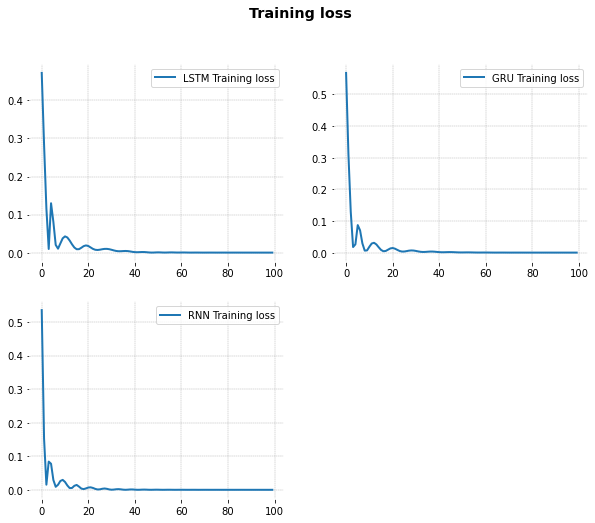

In [23]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(hist_LSTM, label="LSTM Training loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(hist_GRU, label="GRU Training loss")
plt.legend()

plt.subplot(2,2,3)
plt.plot(hist_RNN, label="RNN Training loss")
plt.legend()

plt.suptitle("Training loss")
plt.show()

In [24]:
# make predictions
y_test_pred1 = model_LSTM(x_test)
test_loss_LSTM = loss_fn(y_test_pred1, y_test_lstm).item()

y_test_pred2 = model_GRU(x_test)
test_loss_GRU = loss_fn(y_test_pred2, y_test_gru).item()

y_test_pred3 = model_RNN(x_test)
test_loss_RNN = loss_fn(y_test_pred3, y_test_rnn).item()

print('test loss for LSTM is ',test_loss_LSTM)
print('test loss for GRU is ',test_loss_GRU)
print('test loss for RNN is ',test_loss_RNN)


test loss for LSTM is  0.10294702649116516
test loss for GRU is  0.001920685637742281
test loss for RNN is  0.0018522224854677916


/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1450, 4])) that is different to the input size (torch.Size([1450, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## visulazation 

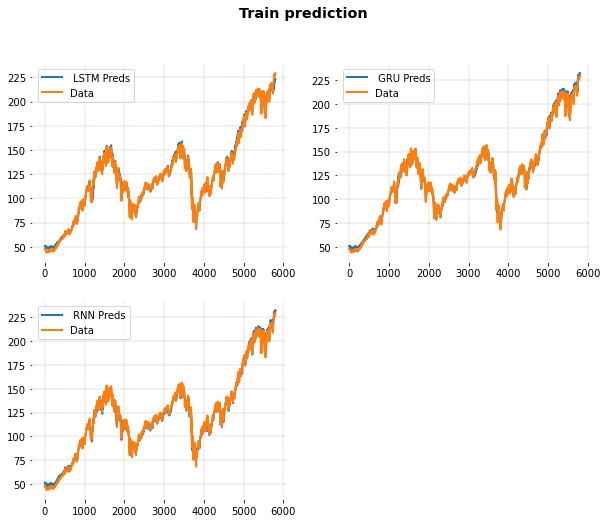

In [25]:
pred_value1 = y_train_pred1.detach().numpy()[:,-1]       
true_value1 = y_train_lstm.detach().numpy()[:,-1] 
# 纵坐标还有负的，因为前面进行缩放，现在让数据还原成原来的大小
# invert predictions
pred_value1 = scaler.inverse_transform(pred_value1.reshape(-1, 1))
true_value1 = scaler.inverse_transform(true_value1.reshape(-1, 1))

pred_value2 = y_train_pred2.detach().numpy()[:,-1]       
true_value2 = y_train_gru.detach().numpy()[:,-1] 
pred_value2 = scaler.inverse_transform(pred_value2.reshape(-1, 1))
true_value2 = scaler.inverse_transform(true_value2.reshape(-1, 1))

pred_value3 = y_train_pred3.detach().numpy()[:,-1]       
true_value3 = y_train_rnn.detach().numpy()[:,-1] 
pred_value3 = scaler.inverse_transform(pred_value3.reshape(-1, 1))
true_value3 = scaler.inverse_transform(true_value3.reshape(-1, 1))

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(pred_value1, label=" LSTM Preds")    # 预测值
plt.plot(true_value1, label="Data")           # 真实值
plt.legend()

plt.subplot(2,2,2)
plt.plot(pred_value2, label=" GRU Preds")    # 预测值
plt.plot(true_value2, label="Data")          # 真实值
plt.legend()

plt.subplot(2,2,3)
plt.plot(pred_value3, label=" RNN Preds")    # 预测值
plt.plot(true_value3, label="Data")          # 真实值
plt.legend()

plt.suptitle("Train prediction")
plt.show()


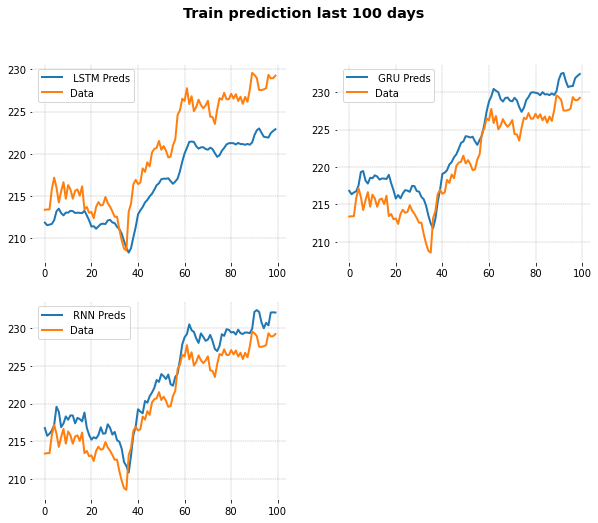

In [26]:
## check last 100 days train prediction
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(pred_value1[-100:], label=" LSTM Preds")    # 预测值
plt.plot(true_value1[-100:], label="Data")           # 真实值
plt.legend()

plt.subplot(2,2,2)
plt.plot(pred_value2[-100:], label=" GRU Preds")    # 预测值
plt.plot(true_value2[-100:], label="Data")          # 真实值
plt.legend()

plt.subplot(2,2,3)
plt.plot(pred_value3[-100:], label=" RNN Preds")    # 预测值
plt.plot(true_value3[-100:], label="Data")          # 真实值
plt.legend()

plt.suptitle("Train prediction last 100 days")
plt.show()

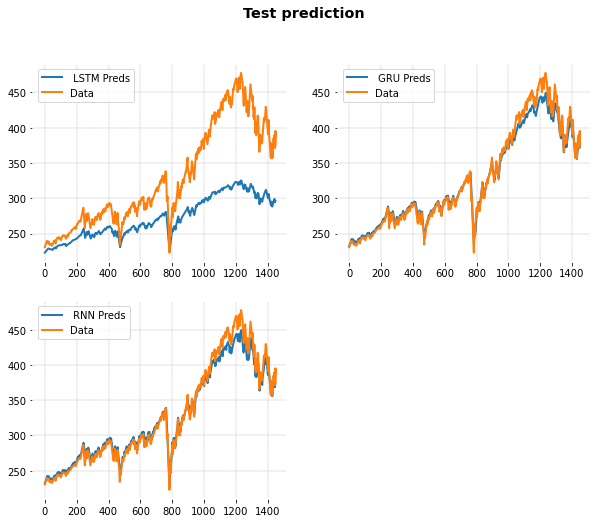

In [27]:
# Prediction on test data

"测试集效果图"
pred_value1 = y_test_pred1.detach().numpy()[:,-1]    
true_value1 = y_test_lstm.detach().numpy()[:,-1]
pred_value1 = scaler.inverse_transform(pred_value1.reshape(-1, 1))
true_value1 = scaler.inverse_transform(true_value1.reshape(-1, 1))

pred_value2 = y_test_pred2.detach().numpy()[:,-1]       
true_value2 = y_test_gru.detach().numpy()[:,-1] 
pred_value2 = scaler.inverse_transform(pred_value2.reshape(-1, 1))
true_value2 = scaler.inverse_transform(true_value2.reshape(-1, 1))

pred_value3 = y_test_pred3.detach().numpy()[:,-1]       
true_value3 = y_test_rnn.detach().numpy()[:,-1] 
pred_value3 = scaler.inverse_transform(pred_value3.reshape(-1, 1))
true_value3 = scaler.inverse_transform(true_value3.reshape(-1, 1))

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(pred_value1, label=" LSTM Preds")    # 预测值
plt.plot(true_value1, label="Data")           # 真实值
plt.legend()

plt.subplot(2,2,2)
plt.plot(pred_value2, label=" GRU Preds")    # 预测值
plt.plot(true_value2, label="Data")          # 真实值
plt.legend()

plt.subplot(2,2,3)
plt.plot(pred_value3, label=" RNN Preds")    # 预测值
plt.plot(true_value3, label="Data")          # 真实值
plt.legend()

plt.suptitle("Test prediction")
plt.show()


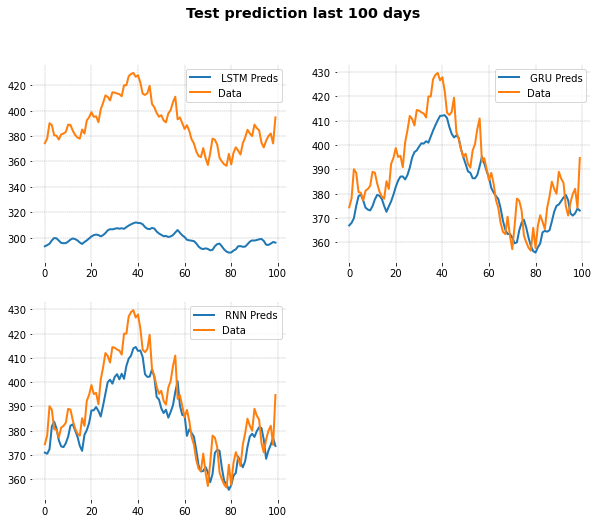

In [28]:
## check last 100 days test prediction
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(pred_value1[-100:], label=" LSTM Preds")    # 预测值
plt.plot(true_value1[-100:], label="Data")           # 真实值
plt.legend()

plt.subplot(2,2,2)
plt.plot(pred_value2[-100:], label=" GRU Preds")    # 预测值
plt.plot(true_value2[-100:], label="Data")          # 真实值
plt.legend()

plt.subplot(2,2,3)
plt.plot(pred_value3[-100:], label=" RNN Preds")    # 预测值
plt.plot(true_value3[-100:], label="Data")          # 真实值
plt.legend()

plt.suptitle("Test prediction last 100 days")
plt.show()

## Experiment on GRU

#### Different sliding window

In [29]:
# 设每条数据序列有20组数据
seq10 = 10
x_train10, y_train10, x_test10, y_test10 = split_data(df_main, seq10)

seq50 = 50
x_train50, y_train50, x_test50, y_test50 = split_data(df_main, seq50)

seq100 = 100
x_train100, y_train100, x_test100, y_test100 = split_data(df_main, seq100)


In [30]:
# tranfer data as tensor

x_train10 = torch.from_numpy(x_train10).type(torch.Tensor)
x_test10 = torch.from_numpy(x_test10).type(torch.Tensor)
y_train_gru10 = torch.from_numpy(y_train10).type(torch.Tensor)
y_test_gru10 = torch.from_numpy(y_test10).type(torch.Tensor)

x_train50 = torch.from_numpy(x_train50).type(torch.Tensor)
x_test50 = torch.from_numpy(x_test50).type(torch.Tensor)
y_train_gru50 = torch.from_numpy(y_train50).type(torch.Tensor)
y_test_gru50 = torch.from_numpy(y_test50).type(torch.Tensor)

x_train100 = torch.from_numpy(x_train100).type(torch.Tensor)
x_test100 = torch.from_numpy(x_test100).type(torch.Tensor)
y_train_gru100 = torch.from_numpy(y_train100).type(torch.Tensor)
y_test_gru100 = torch.from_numpy(y_test100).type(torch.Tensor)


In [31]:
# train model GRU with sliding window 10
optimiser_GRU10 = torch.optim.Adam(model_GRU.parameters(), lr=0.01) # 使用Adam优化算法

hist_GRU10 = np.zeros(num_epochs)
for t in range(num_epochs):
    
    y_train_pred10 = model_GRU(x_train10)

    loss = loss_fn(y_train_pred10, y_train_gru10) ###y_train_gru
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_GRU with sliding window 10 MSE: ", loss.item())
    hist_GRU10[t] = loss.item()

    optimiser_GRU10.zero_grad()
    loss.backward()
    optimiser_GRU10.step()

/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([5808, 4])) that is different to the input size (torch.Size([5808, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  10 model_GRU with sliding window 10 MSE:  0.01198388822376728
Epoch  20 model_GRU with sliding window 10 MSE:  0.0006385417655110359
Epoch  30 model_GRU with sliding window 10 MSE:  0.001197169185616076
Epoch  40 model_GRU with sliding window 10 MSE:  0.00020861701341345906
Epoch  50 model_GRU with sliding window 10 MSE:  0.0002721885102801025
Epoch  60 model_GRU with sliding window 10 MSE:  9.566247899783775e-05
Epoch  70 model_GRU with sliding window 10 MSE:  8.873263141140342e-05
Epoch  80 model_GRU with sliding window 10 MSE:  8.234304550569504e-05
Epoch  90 model_GRU with sliding window 10 MSE:  7.119803194655105e-05


In [32]:
# train model GRU with sliding window 50
optimiser_GRU50 = torch.optim.Adam(model_GRU.parameters(), lr=0.01) # 使用Adam优化算法

hist_GRU50 = np.zeros(num_epochs)
for t in range(num_epochs):
    
    y_train_pred50 = model_GRU(x_train50)

    loss = loss_fn(y_train_pred50, y_train_gru50) ###y_train_gru
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_GRU with sliding window 50 MSE: ", loss.item())
    hist_GRU50[t] = loss.item()

    optimiser_GRU50.zero_grad()
    loss.backward()
    optimiser_GRU50.step()

/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([5776, 4])) that is different to the input size (torch.Size([5776, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  10 model_GRU with sliding window 50 MSE:  0.005818680860102177
Epoch  20 model_GRU with sliding window 50 MSE:  0.0012933188118040562
Epoch  30 model_GRU with sliding window 50 MSE:  7.993436884135008e-05
Epoch  40 model_GRU with sliding window 50 MSE:  0.00020787297398783267
Epoch  50 model_GRU with sliding window 50 MSE:  0.00015218557382468134
Epoch  60 model_GRU with sliding window 50 MSE:  9.294594201492146e-05
Epoch  70 model_GRU with sliding window 50 MSE:  6.553190905833617e-05
Epoch  80 model_GRU with sliding window 50 MSE:  5.2722440159413964e-05
Epoch  90 model_GRU with sliding window 50 MSE:  4.578328662319109e-05


In [33]:
# train model GRU with sliding window 100
optimiser_GRU100 = torch.optim.Adam(model_GRU.parameters(), lr=0.01) # 使用Adam优化算法

hist_GRU100 = np.zeros(num_epochs)
for t in range(num_epochs):
    
    y_train_pred100 = model_GRU(x_train100)

    loss = loss_fn(y_train_pred100, y_train_gru100) ###y_train_gru
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_GRU with sliding window 100 MSE: ", loss.item())
    hist_GRU100[t] = loss.item()

    optimiser_GRU100.zero_grad()
    loss.backward()
    optimiser_GRU100.step()

/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([5736, 4])) that is different to the input size (torch.Size([5736, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  10 model_GRU with sliding window 100 MSE:  0.004805597010999918
Epoch  20 model_GRU with sliding window 100 MSE:  0.0013014806900173426
Epoch  30 model_GRU with sliding window 100 MSE:  7.663974247407168e-05
Epoch  40 model_GRU with sliding window 100 MSE:  0.00019280244305264205
Epoch  50 model_GRU with sliding window 100 MSE:  0.0001434042933396995
Epoch  60 model_GRU with sliding window 100 MSE:  8.670164970681071e-05
Epoch  70 model_GRU with sliding window 100 MSE:  6.284353730734438e-05
Epoch  80 model_GRU with sliding window 100 MSE:  5.285008592181839e-05
Epoch  90 model_GRU with sliding window 100 MSE:  4.731919398182072e-05


In [34]:
# make predictions
y_test_pred10 = model_GRU(x_test10)
test_loss_GRU10 = loss_fn(y_test_pred10, y_test_gru10).item()
y_test_pred50 = model_GRU(x_test50)
test_loss_GRU50 = loss_fn(y_test_pred50, y_test_gru50).item()
y_test_pred100 = model_GRU(x_test100)
test_loss_GRU100 = loss_fn(y_test_pred100, y_test_gru100).item()

print('test MSE for GRU with sliding window 10 is ',test_loss_GRU10)
print('test MSE for GRU with sliding window 50 is ',test_loss_GRU50)
print('test MSe for GRU with sliding window 100 is ',test_loss_GRU100)


test MSE for GRU with sliding window 10 is  0.02617023140192032
test MSE for GRU with sliding window 50 is  0.02604748122394085
test MSe for GRU with sliding window 100 is  0.026172710582613945


/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1452, 4])) that is different to the input size (torch.Size([1452, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1444, 4])) that is different to the input size (torch.Size([1444, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1434, 4])) that is different to the input size (torch.Size([1434, 1])). This will likely lead to incorrect results due to broa

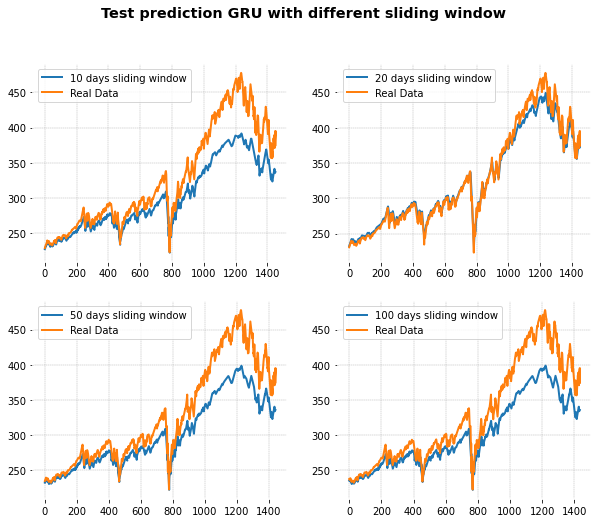

In [35]:
# plot GRU model with differnt sliding window

## baseline GRU model with 20 sliding window
pred_value2 = y_test_pred2.detach().numpy()[:,-1]       
true_value2 = y_test_gru.detach().numpy()[:,-1] 
pred_value2 = scaler.inverse_transform(pred_value2.reshape(-1, 1))
true_value2 = scaler.inverse_transform(true_value2.reshape(-1, 1))

pred_value10 = y_test_pred10.detach().numpy()[:,-1]       
true_value10 = y_test_gru10.detach().numpy()[:,-1] 
pred_value10 = scaler.inverse_transform(pred_value10.reshape(-1, 1))
true_value10 = scaler.inverse_transform(true_value10.reshape(-1, 1))

pred_value50 = y_test_pred50.detach().numpy()[:,-1]       
true_value50 = y_test_gru50.detach().numpy()[:,-1] 
pred_value50 = scaler.inverse_transform(pred_value50.reshape(-1, 1))
true_value50 = scaler.inverse_transform(true_value50.reshape(-1, 1))

pred_value100 = y_test_pred100.detach().numpy()[:,-1]       
true_value100 = y_test_gru100.detach().numpy()[:,-1] 
pred_value100 = scaler.inverse_transform(pred_value100.reshape(-1, 1))
true_value100 = scaler.inverse_transform(true_value100.reshape(-1, 1))

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(pred_value10, label="10 days sliding window")    # 预测值
plt.plot(true_value10, label="Real Data")           # 真实值
plt.legend()

plt.subplot(2,2,2)
plt.plot(pred_value2, label="20 days sliding window")    # 预测值
plt.plot(true_value2, label="Real Data")          # 真实值
plt.legend()

plt.subplot(2,2,3)
plt.plot(pred_value50, label="50 days sliding window")    # 预测值
plt.plot(true_value50, label="Real Data")          # 真实值
plt.legend()

plt.subplot(2,2,4)
plt.plot(pred_value100, label="100 days sliding window")    # 预测值
plt.plot(true_value100, label="Real Data")          # 真实值
plt.legend()

plt.suptitle("Test prediction GRU with different sliding window")
plt.show()



#### Different hidden layer

In [36]:
# bulid different GRU model with differnet hidden layers
model_GRU_hidden2 = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=2)
model_GRU_hidden3 = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=3)
model_GRU_hidden5 = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=5)

In [37]:
# train model GRU with diferent hidden layers (sliding window 20)
optimiser_GRU_hidden2 = torch.optim.Adam(model_GRU_hidden2.parameters(), lr=0.01) 

hist_GRU_hidden2 = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred_hidden2 = model_GRU_hidden2(x_train)
    loss = loss_fn(y_train_pred_hidden2, y_train_gru) 
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_GRU with hidden layer 2 MSE: ", loss.item())
    hist_GRU_hidden2[t] = loss.item()

    optimiser_GRU_hidden2.zero_grad()
    loss.backward()
    optimiser_GRU_hidden2.step()

/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([5800, 4])) that is different to the input size (torch.Size([5800, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  10 model_GRU with hidden layer 2 MSE:  0.01913703978061676
Epoch  20 model_GRU with hidden layer 2 MSE:  0.016342049464583397
Epoch  30 model_GRU with hidden layer 2 MSE:  0.003512169001623988
Epoch  40 model_GRU with hidden layer 2 MSE:  0.0013967053964734077
Epoch  50 model_GRU with hidden layer 2 MSE:  0.00030136510031297803
Epoch  60 model_GRU with hidden layer 2 MSE:  0.00027738625067286193
Epoch  70 model_GRU with hidden layer 2 MSE:  0.0001581054093549028
Epoch  80 model_GRU with hidden layer 2 MSE:  0.00010314462269889191
Epoch  90 model_GRU with hidden layer 2 MSE:  8.166601037373766e-05


In [38]:
# train model GRU with diferent hidden layers (sliding window 20)
optimiser_GRU_hidden3 = torch.optim.Adam(model_GRU_hidden3.parameters(), lr=0.01) 

hist_GRU_hidden3 = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred_hidden3 = model_GRU_hidden3(x_train)
    loss = loss_fn(y_train_pred_hidden3, y_train_gru) 
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_GRU with hidden layer 3 MSE: ", loss.item())
    hist_GRU_hidden3[t] = loss.item()

    optimiser_GRU_hidden3.zero_grad()
    loss.backward()
    optimiser_GRU_hidden3.step()

Epoch  10 model_GRU with hidden layer 3 MSE:  0.010724571533501148
Epoch  20 model_GRU with hidden layer 3 MSE:  0.004101940896362066
Epoch  30 model_GRU with hidden layer 3 MSE:  0.0005406184936873615
Epoch  40 model_GRU with hidden layer 3 MSE:  0.0001888075639726594
Epoch  50 model_GRU with hidden layer 3 MSE:  0.00013343029422685504
Epoch  60 model_GRU with hidden layer 3 MSE:  9.221586515195668e-05
Epoch  70 model_GRU with hidden layer 3 MSE:  9.555368887959048e-05
Epoch  80 model_GRU with hidden layer 3 MSE:  7.977528002811596e-05
Epoch  90 model_GRU with hidden layer 3 MSE:  7.102868403308094e-05


In [39]:
# train model GRU with diferent hidden layers (sliding window 20)
optimiser_GRU_hidden5 = torch.optim.Adam(model_GRU_hidden5.parameters(), lr=0.01) 

hist_GRU_hidden5 = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred_hidden5 = model_GRU_hidden5(x_train)
    loss = loss_fn(y_train_pred_hidden5, y_train_gru) 
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_GRU with hidden layer 5 MSE: ", loss.item())
    hist_GRU_hidden5[t] = loss.item()

    optimiser_GRU_hidden5.zero_grad()
    loss.backward()
    optimiser_GRU_hidden5.step()

Epoch  10 model_GRU with hidden layer 5 MSE:  0.031713370233774185
Epoch  20 model_GRU with hidden layer 5 MSE:  0.005603262688964605
Epoch  30 model_GRU with hidden layer 5 MSE:  0.0016774572432041168
Epoch  40 model_GRU with hidden layer 5 MSE:  0.00030767786665819585
Epoch  50 model_GRU with hidden layer 5 MSE:  0.00046978177851997316
Epoch  60 model_GRU with hidden layer 5 MSE:  0.0002301443018950522
Epoch  70 model_GRU with hidden layer 5 MSE:  0.00018590046965982765
Epoch  80 model_GRU with hidden layer 5 MSE:  0.0001619386166566983
Epoch  90 model_GRU with hidden layer 5 MSE:  0.0001396837760694325


In [40]:
# make predictions
y_test_pred_hidden2 = model_GRU_hidden2(x_test)
test_loss_hidden2 = loss_fn(y_test_pred_hidden2, y_test_gru).item()
y_test_pred_hidden3 = model_GRU_hidden3(x_test)
test_loss_hidden3 = loss_fn(y_test_pred_hidden3, y_test_gru).item()
y_test_pred_hidden5 = model_GRU_hidden5(x_test)
test_loss_hidden5 = loss_fn(y_test_pred_hidden5, y_test_gru).item()

print('test MSE for GRU with hidden layer 2 is ',test_loss_hidden2)
print('test MSE for GRU with hidden layer 3 is ',test_loss_hidden3)
print('test MSE for GRU with hidden layer 5 is ',test_loss_hidden5)

test MSE for GRU with hidden layer 2 is  0.021078331395983696
test MSE for GRU with hidden layer 3 is  0.06387194246053696
test MSE for GRU with hidden layer 5 is  0.12418143451213837


/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1450, 4])) that is different to the input size (torch.Size([1450, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


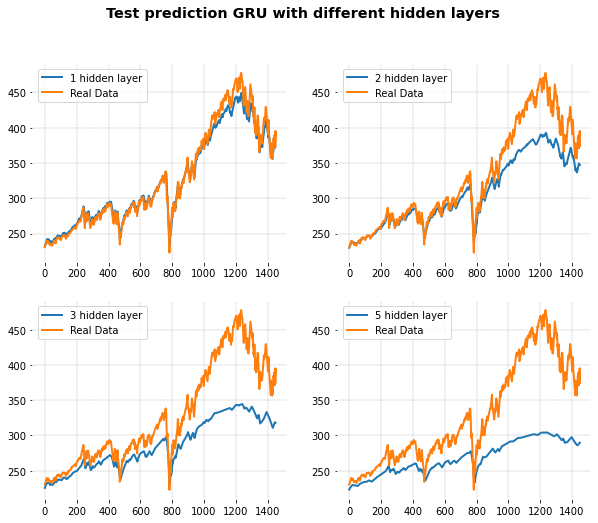

In [41]:
## baseline GRU model with 1 hidden layer
pred_value2 = y_test_pred2.detach().numpy()[:,-1]       
true_value2 = y_test_gru.detach().numpy()[:,-1] 
pred_value2 = scaler.inverse_transform(pred_value2.reshape(-1, 1))
true_value2 = scaler.inverse_transform(true_value2.reshape(-1, 1))

pred_value_hidden2 = y_test_pred_hidden2.detach().numpy()[:,-1]       
true_value_hidden2 = y_test_gru.detach().numpy()[:,-1] 
pred_value_hidden2 = scaler.inverse_transform(pred_value_hidden2.reshape(-1, 1))
true_value_hidden2 = scaler.inverse_transform(true_value_hidden2.reshape(-1, 1))

pred_value_hidden3 = y_test_pred_hidden3.detach().numpy()[:,-1]       
true_value_hidden3 = y_test_gru.detach().numpy()[:,-1] 
pred_value_hidden3 = scaler.inverse_transform(pred_value_hidden3.reshape(-1, 1))
true_value_hidden3 = scaler.inverse_transform(true_value_hidden3.reshape(-1, 1))

pred_value_hidden5 = y_test_pred_hidden5.detach().numpy()[:,-1]       
true_value_hidden5 = y_test_gru.detach().numpy()[:,-1] 
pred_value_hidden5 = scaler.inverse_transform(pred_value_hidden5.reshape(-1, 1))
true_value_hidden5 = scaler.inverse_transform(true_value_hidden5.reshape(-1, 1))

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(pred_value2, label="1 hidden layer")    # 预测值
plt.plot(true_value2, label="Real Data")          # 真实值
plt.legend()

plt.subplot(2,2,2)
plt.plot(pred_value_hidden2, label="2 hidden layer")    # 预测值
plt.plot(true_value_hidden2, label="Real Data")          # 真实值
plt.legend()

plt.subplot(2,2,3)
plt.plot(pred_value_hidden3, label="3 hidden layer")    # 预测值
plt.plot(true_value_hidden3, label="Real Data")          # 真实值
plt.legend()

plt.subplot(2,2,4)
plt.plot(pred_value_hidden5, label="5 hidden layer")    # 预测值
plt.plot(true_value_hidden5, label="Real Data")          # 真实值
plt.legend()

plt.suptitle("Test prediction GRU with different hidden layers")
plt.show()

#### Different datasets

In [42]:
OXY=pd.read_csv('./data/OXY_rawdata.csv',index_col=0)
KO=pd.read_csv('./data/KO_rawdata.csv',index_col=0)
TSLA=pd.read_csv('./data/TSLA_rawdata.csv',index_col=0)

print("the siz of OXY dataset is ", OXY.shape)
print("the siz of KO dataset is ", KO.shape)
print("the siz of TSLA dataset is ", TSLA.shape)

the siz of OXY dataset is  (10052, 7)
the siz of KO dataset is  (14568, 7)
the siz of TSLA dataset is  (2486, 7)


In [43]:
# preprocessing the dataset
sel_col = ['Open', 'High', 'Low', 'Close']  
df_mainOXY = OXY[sel_col]
df_mainKO = KO[sel_col]
df_mainTSLA = TSLA[sel_col]

scaler = MinMaxScaler(feature_range=(-1, 1))  
for col in sel_col:                           # 这里不能进行统一进行缩放，因为fit_transform返回值是numpy类型
    df_mainOXY[col] = scaler.fit_transform(df_mainOXY[col].values.reshape(-1,1))
    df_mainKO[col] = scaler.fit_transform(df_mainKO[col].values.reshape(-1,1))
    df_mainTSLA[col] = scaler.fit_transform(df_mainTSLA[col].values.reshape(-1,1))

df_mainOXY.dropna()                      
df_mainOXY = df_mainOXY.astype(np.float32)  
df_mainKO.dropna()                      
df_mainKO = df_mainKO.astype(np.float32) 
df_mainTSLA.dropna()                      
df_mainTSLA = df_mainTSLA.astype(np.float32) 

/var/folders/tr/3_k_czmn2552n9rftmys1pwh0000gn/T/ipykernel_24349/2135183684.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mainOXY[col] = scaler.fit_transform(df_mainOXY[col].values.reshape(-1,1))
/var/folders/tr/3_k_czmn2552n9rftmys1pwh0000gn/T/ipykernel_24349/2135183684.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mainKO[col] = scaler.fit_transform(df_mainKO[col].values.reshape(-1,1))
/var/folders/tr/3_k_czmn2552n9rftmys1pwh0000gn/T/ipykernel_24349/2135183684.py:11: SettingWithCopyWarni

In [44]:
seq = 20

x_trainOXY, y_trainOXY, x_testOXY, y_testOXY = split_data(df_mainOXY, seq)
x_trainKO, y_trainKO, x_testKO, y_testKO = split_data(df_mainKO, seq)
x_trainTSLA, y_trainTSLA, x_testTSLA, y_testTSLA = split_data(df_mainTSLA, seq)

In [45]:
# tranfer data as tensor
x_trainOXY = torch.from_numpy(x_trainOXY).type(torch.Tensor)
x_testOXY = torch.from_numpy(x_testOXY).type(torch.Tensor)
y_trainOXY = torch.from_numpy(y_trainOXY).type(torch.Tensor)
y_testOXY = torch.from_numpy(y_testOXY).type(torch.Tensor)

x_trainKO = torch.from_numpy(x_trainKO).type(torch.Tensor)
x_testKO = torch.from_numpy(x_testKO).type(torch.Tensor)
y_trainKO = torch.from_numpy(y_trainKO).type(torch.Tensor)
y_testKO = torch.from_numpy(y_testKO).type(torch.Tensor)

x_trainTSLA = torch.from_numpy(x_trainTSLA).type(torch.Tensor)
x_testTSLA = torch.from_numpy(x_testTSLA).type(torch.Tensor)
y_trainTSLA = torch.from_numpy(y_trainTSLA).type(torch.Tensor)
y_testTSLA = torch.from_numpy(y_testTSLA).type(torch.Tensor)


In [46]:
model_GRU = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
optimiser_GRU = torch.optim.Adam(model_GRU.parameters(), lr=0.01) # 使用Adam优化算法

# START TRAINING
# train model on OXY
hist_GRU_OXY = np.zeros(num_epochs)
for t in range(num_epochs):
   
    y_train_predOXY = model_GRU(x_trainOXY)

    loss = loss_fn(y_train_predOXY, y_trainOXY) 
    if t % 10 == 0 and t !=0:                  
        print("Epoch ", t, "model_GRU on OXY MSE: ", loss.item())
    hist_GRU_OXY[t] = loss.item()

    optimiser_GRU.zero_grad()
    loss.backward()
    optimiser_GRU.step()

/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([8026, 4])) that is different to the input size (torch.Size([8026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  10 model_GRU on OXY MSE:  0.030088113620877266
Epoch  20 model_GRU on OXY MSE:  0.014201369136571884
Epoch  30 model_GRU on OXY MSE:  0.0028066725935786963
Epoch  40 model_GRU on OXY MSE:  0.0005318972398526967
Epoch  50 model_GRU on OXY MSE:  0.0006126959342509508
Epoch  60 model_GRU on OXY MSE:  0.0006039926083758473
Epoch  70 model_GRU on OXY MSE:  0.00041324467747472227
Epoch  80 model_GRU on OXY MSE:  0.00039521808503195643
Epoch  90 model_GRU on OXY MSE:  0.00038197863614186645


In [47]:
model_GRU = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
optimiser_GRU = torch.optim.Adam(model_GRU.parameters(), lr=0.01) # 使用Adam优化算法

# START TRAINING
# train model on KO
hist_GRU_KO = np.zeros(num_epochs)
for t in range(num_epochs):
   
    y_train_predKO = model_GRU(x_trainKO)

    loss = loss_fn(y_train_predKO, y_trainKO) 
    if t % 10 == 0 and t !=0:                  
        print("Epoch ", t, "model_GRU on KO MSE: ", loss.item())
    hist_GRU_KO[t] = loss.item()

    optimiser_GRU.zero_grad()
    loss.backward()
    optimiser_GRU.step()

/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([11638, 4])) that is different to the input size (torch.Size([11638, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  10 model_GRU on KO MSE:  0.015259106643497944
Epoch  20 model_GRU on KO MSE:  0.010494767688214779
Epoch  30 model_GRU on KO MSE:  0.004487555008381605
Epoch  40 model_GRU on KO MSE:  0.002075780648738146
Epoch  50 model_GRU on KO MSE:  0.000809891673270613
Epoch  60 model_GRU on KO MSE:  0.0002606503840070218
Epoch  70 model_GRU on KO MSE:  0.00022230521426536143
Epoch  80 model_GRU on KO MSE:  0.00021390531037468463
Epoch  90 model_GRU on KO MSE:  0.00017383693193551153


In [48]:
model_GRU = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
optimiser_GRU = torch.optim.Adam(model_GRU.parameters(), lr=0.01) # 使用Adam优化算法

# START TRAINING
# train model on TSLA
hist_GRU_TSLA = np.zeros(num_epochs)
for t in range(num_epochs):
   
    y_train_predTSLA = model_GRU(x_trainTSLA)

    loss = loss_fn(y_train_predTSLA, y_trainTSLA) 
    if t % 10 == 0 and t !=0:                  
        print("Epoch ", t, "model_GRU on TSLA MSE: ", loss.item())
    hist_GRU_TSLA[t] = loss.item()

    optimiser_GRU.zero_grad()
    loss.backward()
    optimiser_GRU.step()

/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1973, 4])) that is different to the input size (torch.Size([1973, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  10 model_GRU on TSLA MSE:  0.013412188738584518
Epoch  20 model_GRU on TSLA MSE:  0.0032868224661797285
Epoch  30 model_GRU on TSLA MSE:  0.002994735725224018
Epoch  40 model_GRU on TSLA MSE:  0.0025952314026653767
Epoch  50 model_GRU on TSLA MSE:  0.0023424781393259764
Epoch  60 model_GRU on TSLA MSE:  0.0020953372586518526
Epoch  70 model_GRU on TSLA MSE:  0.001832247362472117
Epoch  80 model_GRU on TSLA MSE:  0.0015344057464972138
Epoch  90 model_GRU on TSLA MSE:  0.0012215020833536983


In [49]:
# make predictions
y_test_pred_OXY = model_GRU(x_testOXY)
test_loss_OXY = loss_fn(y_test_pred_OXY, y_testOXY).item()

y_test_pred_KO = model_GRU(x_testKO)
test_loss_KO = loss_fn(y_test_pred_KO, y_testKO).item()

y_test_pred_TSLA = model_GRU(x_testTSLA)
test_loss_TSLA = loss_fn(y_test_pred_TSLA, y_testTSLA).item()

print('test MSE for GRU with OXY is ',test_loss_OXY)
print('test MSE for GRU with KO is ',test_loss_KO)
print('test MSE for GRU with TSLA is ',test_loss_TSLA)

test MSE for GRU with OXY is  0.04368403181433678
test MSE for GRU with KO is  0.09302917867898941
test MSE for GRU with TSLA is  0.08637356758117676


/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([2006, 4])) that is different to the input size (torch.Size([2006, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([2910, 4])) that is different to the input size (torch.Size([2910, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/melindadong/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([493, 4])) that is different to the input size (torch.Size([493, 1])). This will likely lead to incorrect results due to broadc

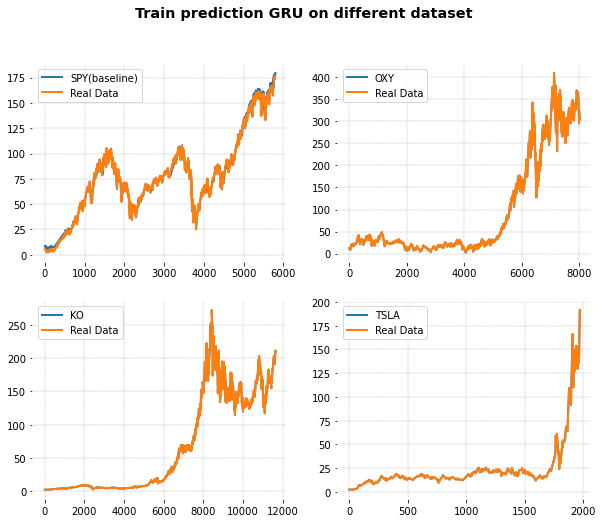

In [51]:
## baseline GRU model with 1 hidden layer
pred_value2 = y_train_pred2.detach().numpy()[:,-1]       
true_value2 = y_train_gru.detach().numpy()[:,-1] 
pred_value2 = scaler.inverse_transform(pred_value2.reshape(-1, 1))
true_value2 = scaler.inverse_transform(true_value2.reshape(-1, 1))

pred_valueOXY = y_trainOXY.detach().numpy()[:,-1]       
true_valueOXY = y_trainOXY.detach().numpy()[:,-1] 
pred_valueOXY = scaler.inverse_transform(pred_valueOXY.reshape(-1, 1))
true_valueOXY = scaler.inverse_transform(true_valueOXY.reshape(-1, 1))

pred_valueKO = y_trainKO.detach().numpy()[:,-1]       
true_valueKO = y_trainKO.detach().numpy()[:,-1] 
pred_valueKO = scaler.inverse_transform(pred_valueKO.reshape(-1, 1))
true_valueKO = scaler.inverse_transform(true_valueKO.reshape(-1, 1))

pred_valueTSLA = y_trainTSLA.detach().numpy()[:,-1]       
true_valueTSLA = y_trainTSLA.detach().numpy()[:,-1] 
pred_valueTSLA = scaler.inverse_transform(pred_valueTSLA.reshape(-1, 1))
true_valueTSLA = scaler.inverse_transform(true_valueTSLA.reshape(-1, 1))


plt.figure(figsize=(10,8))
# the original SPY dataset
plt.subplot(2,2,1)
plt.plot(pred_value2, label="SPY(baseline)")    # 预测值
plt.plot(true_value2, label="Real Data")          # 真实值
plt.legend()

plt.subplot(2,2,2)
plt.plot(pred_valueOXY, label="OXY")    # 预测值
plt.plot(true_valueOXY, label="Real Data")          # 真实值
plt.legend()

plt.subplot(2,2,3)
plt.plot(pred_valueKO, label="KO")    # 预测值
plt.plot(true_valueKO, label="Real Data")          # 真实值
plt.legend()

plt.subplot(2,2,4)
plt.plot(pred_valueTSLA, label="TSLA")    # 预测值
plt.plot(true_valueTSLA, label="Real Data")          # 真实值
plt.legend()

plt.suptitle("Train prediction GRU on different dataset")
plt.show()

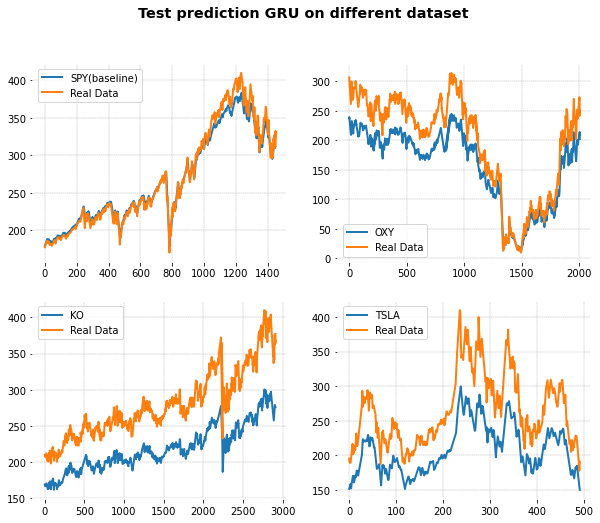

In [50]:
## baseline GRU model with 1 hidden layer
pred_value2 = y_test_pred2.detach().numpy()[:,-1]       
true_value2 = y_test_gru.detach().numpy()[:,-1] 
pred_value2 = scaler.inverse_transform(pred_value2.reshape(-1, 1))
true_value2 = scaler.inverse_transform(true_value2.reshape(-1, 1))

pred_valueOXY = y_test_pred_OXY.detach().numpy()[:,-1]       
true_valueOXY = y_testOXY.detach().numpy()[:,-1] 
pred_valueOXY = scaler.inverse_transform(pred_valueOXY.reshape(-1, 1))
true_valueOXY = scaler.inverse_transform(true_valueOXY.reshape(-1, 1))

pred_valueKO = y_test_pred_KO.detach().numpy()[:,-1]       
true_valueKO = y_testKO.detach().numpy()[:,-1] 
pred_valueKO = scaler.inverse_transform(pred_valueKO.reshape(-1, 1))
true_valueKO = scaler.inverse_transform(true_valueKO.reshape(-1, 1))

pred_valueTSLA = y_test_pred_TSLA.detach().numpy()[:,-1]       
true_valueTSLA = y_testTSLA.detach().numpy()[:,-1] 
pred_valueTSLA = scaler.inverse_transform(pred_valueTSLA.reshape(-1, 1))
true_valueTSLA = scaler.inverse_transform(true_valueTSLA.reshape(-1, 1))


plt.figure(figsize=(10,8))
# the original SPY dataset
plt.subplot(2,2,1)
plt.plot(pred_value2, label="SPY(baseline)")     # 预测值
plt.plot(true_value2, label="Real Data")          # 真实值
plt.legend()

plt.subplot(2,2,2)
plt.plot(pred_valueOXY, label="OXY")                # 预测值
plt.plot(true_valueOXY, label="Real Data")          # 真实值
plt.legend()

plt.subplot(2,2,3)
plt.plot(pred_valueKO, label="KO")                 # 预测值
plt.plot(true_valueKO, label="Real Data")          # 真实值
plt.legend()

plt.subplot(2,2,4)
plt.plot(pred_valueTSLA, label="TSLA")               # 预测值
plt.plot(true_valueTSLA, label="Real Data")          # 真实值
plt.legend()

plt.suptitle("Test prediction GRU on different dataset")
plt.show()